$\frac{dx(t)}{dt} = \sigma(y(t) - x(t))\\$

$\frac{dy(t)}{dt} = R x(t) - y(t) - x(t)z(t)\\$


$\frac{dz(t)}{dt} = x(t)y(t) - Bz(t)\\$

$x(0) = c_{1}, y(0) = c_{2}, z(0) = c_{3}\\$


$\sigma = 0.1 \\ R = 0.2 \\ B = 0.3 \\ c_{1} = 0, c_{2} = 1, c_{3} = 0$





In [1]:
import sys
import torch 
import torch.nn as nn 
import torch.optim as optim 
import numpy as np 
from tqdm import tqdm

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 


from utils.MLP import MLP, set_seed
from utils.data import MyDataset, SubdomainDataLoader, DataSampler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mse = torch.nn.MSELoss()
set_seed(42)

In [3]:
START_T = 0
END_T = 50
TOTAL_POINTS = 1000

INPUT_SHAPE = 1
OUTPUT_SHAPE = 3
NUM_HIDDEN_LAYER = 2
NUM_HIDDEN_NEURON = 20


EPOCHS = 50000

SIGMA_ = 0.1
R_ = 0.2
B_ = 0.3
C1_ = 0
C2_ = 1
C3_ = 0




T0 = torch.tensor([[0.0]]).requires_grad_(True)
X0 = torch.tensor([C1_, C2_, C3_], dtype=torch.float).reshape(1, -1)

In [4]:
def system(t, state, sigma, rho, beta):
    x, y, z = state
    dx_dt = sigma * (y-x)
    dy_dt = x * (rho - z) - y 
    dz_dt = x*y - beta* z 
    return [dx_dt, dy_dt, dz_dt]

initial_state = X0.numpy().squeeze(0)
t_span = (START_T, END_T)
t_eval = np.linspace(START_T, END_T, TOTAL_POINTS)
x_num_sol = solve_ivp(system, t_span=t_span, y0=initial_state, args=(SIGMA_,R_, B_), t_eval=t_eval, method='RK45')

x_num = torch.tensor(x_num_sol.y[0].reshape(-1, 1))
y_num = torch.tensor(x_num_sol.y[1].reshape(-1, 1))
z_num = torch.tensor(x_num_sol.y[2].reshape(-1, 1))

In [5]:
whole_dataset = MyDataset(START_T, END_T, TOTAL_POINTS)
domain_dataloader = SubdomainDataLoader(whole_dataset)


In [6]:
model = MLP(input_dim=INPUT_SHAPE, output_dim=OUTPUT_SHAPE, num_hidden_layers=NUM_HIDDEN_LAYER, num_neurons=NUM_HIDDEN_NEURON).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer = optimizer, step_size=500, gamma=0.8)

In [7]:
def loss_fn(t, my, y0, my0):
    my_ = my

    x = my_[:, 0:1]
    y = my_[:, 1:2]
    z = my_[:, 2:3]

    dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(t), create_graph=True)[0]
    dy_dt = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(t), create_graph=True)[0]
    dz_dt = torch.autograd.grad(z, t, grad_outputs=torch.ones_like(t), create_graph=True)[0]

    x_loss = torch.mean((dx_dt - SIGMA_*(y - x))**2)
    y_loss = torch.mean(0.5*(dy_dt - x*(R_-z) + y)**2)
    z_loss = torch.mean((dz_dt - x*y + B_*z)**2)

    init_loss = torch.mean((y0 - my0)**2)
    total_loss = x_loss + y_loss + z_loss + init_loss

    return total_loss

In [8]:
## Training Loop 
pbar = tqdm(range(EPOCHS), desc='Training', leave=True, file=sys.stdout)



for step in pbar:
    sampled_data = next(iter(domain_dataloader)).requires_grad_(True).to(device)
    model.train()
    optimizer.zero_grad()
    mx_ = model(sampled_data)
    
    mx0= model(T0)

    
    loss = loss_fn(sampled_data, mx_, X0, mx0)
    loss.backward()
    optimizer.step()
    lr_scheduler.step()


    model.eval()
    with torch.no_grad():
        m_sol = model(torch.tensor(t_eval, dtype=torch.float).reshape(-1, 1))
        
        m_x = m_sol[:, 0:1]
        m_y = m_sol[:, 1:2]
        m_z = m_sol[:, 2:3]

        x_error = torch.sqrt(mse(m_x, x_num))
        y_error = torch.sqrt(mse(m_y, y_num))
        z_error = torch.sqrt(mse(m_z, z_num))

    error = x_error + y_error + z_error

    pbar.set_postfix_str(f'Loss : {loss.item() :.20f} || Error : {error.item() : 15f}')


Training: 100%|██████████| 50000/50000 [05:24<00:00, 154.21it/s, Loss : 0.00000003847190299666 || Error :        0.000733]


In [9]:
x_error_domain = torch.abs(x_num - m_x)
y_error_domain = torch.abs(y_num - m_y)
z_error_domain = torch.abs(z_num - m_z)

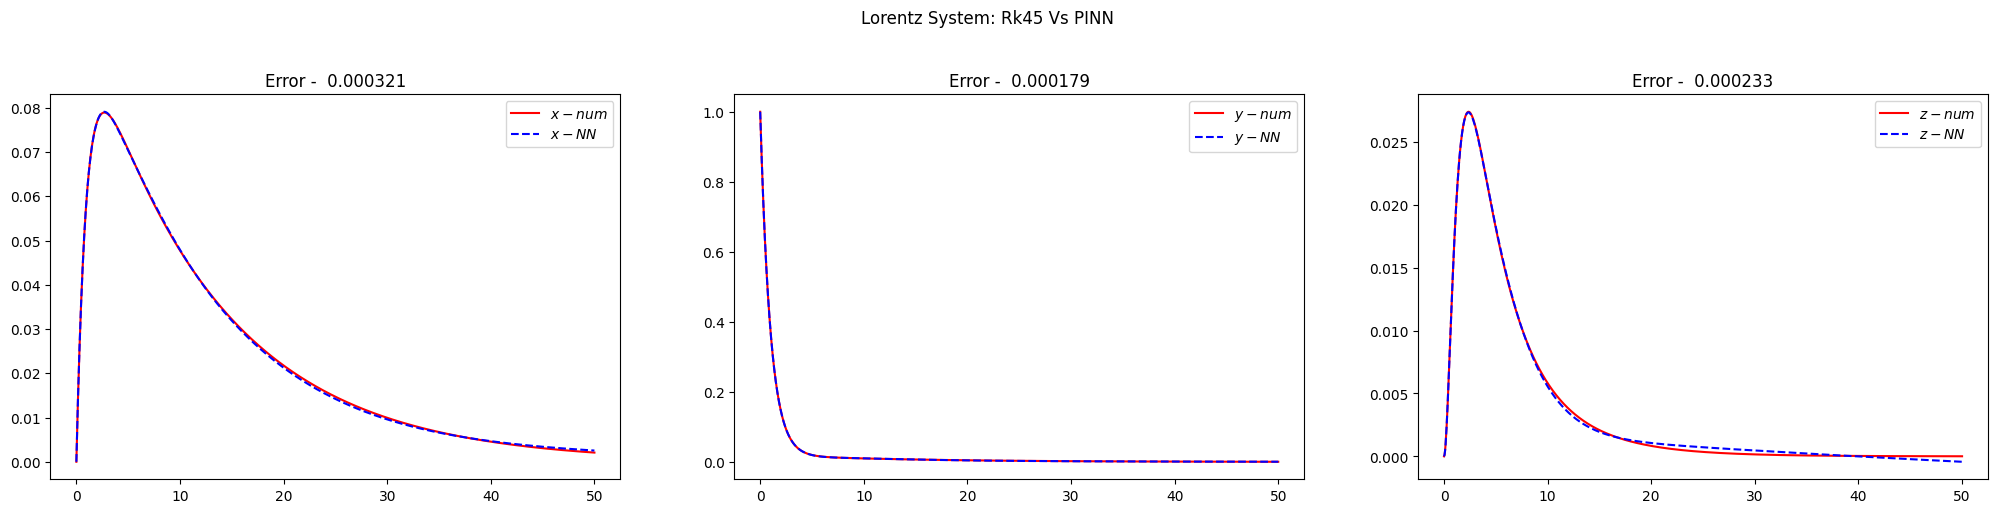

In [10]:


fig, axs = plt.subplots(1, 3, figsize=(25, 5))

axs[0].plot(t_eval, x_num, 'r', label = r'$x-num$')
axs[0].plot(t_eval, m_x, 'b--', label = r'$x-NN$')
axs[0].set_title(f'Error - {x_error : 5f}')
axs[0].legend()

axs[1].plot(t_eval, y_num, 'r', label = r'$y-num$')
axs[1].plot(t_eval, m_y, 'b--', label = r'$y-NN$')
axs[1].set_title(f'Error - {y_error : 5f}')
axs[1].legend()

axs[2].plot(t_eval, z_num, 'r', label = r'$z-num$')
axs[2].plot(t_eval, m_z, 'b--', label = r'$z-NN$')
axs[2].set_title(f'Error - {z_error : 5f}')
axs[2].legend()





plt.suptitle('Lorentz System: Rk45 Vs PINN', y = 1.05)


plt.savefig('Lorentz_PINN.jpg', dpi = 500)
plt.show()

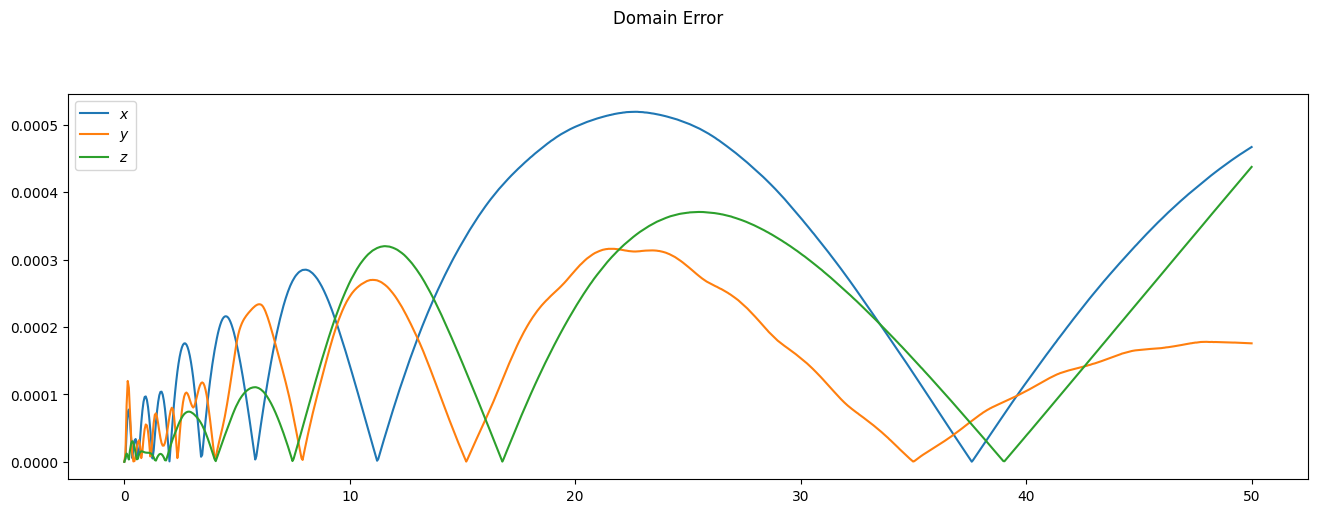

In [11]:


fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(t_eval, x_error_domain, label = r'$x$')
ax.plot(t_eval, y_error_domain, label = r'$y$')
ax.plot(t_eval, z_error_domain, label = r'$z$')
ax.legend()




plt.suptitle('Domain Error', y = 1.05)
plt.show()

In [18]:
pinn_sol = torch.concat((m_x, m_y, m_z), dim=1).numpy()

In [19]:
np.save('Data/PINN_Solve.npy', pinn_sol)

In [21]:
rk4_sol = torch.concat((x_num, y_num, z_num), dim = 1).numpy()

In [22]:
np.save('Data/RK4.npy', rk4_sol)